TITANIC CHALLENGE = {
    "title": "Titanic Challenge",
    "description": "Predict survival on the Titanic using machine learning.",
    "data": {
        "train": "train.csv",
        "test": "test.csv"
    },
    "steps": [
        {
            "name": "Load Data",
            "code": """

In [44]:
# IMPORTS AND SETTINGS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [45]:
# DATA LOADING
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")
data = pd.concat([train, test], sort=False)

In [46]:
# MISSING VALUES HANDLING
# Fill missing values for Age, Embarked, and Fare
data["Age"] = data["Age"].fillna(data["Age"].median())
data["Embarked"] = data["Embarked"].fillna(data["Embarked"].mode()[0])
data["Fare"] = data["Fare"].fillna(data["Fare"].median())

# Drop Cabin due to too many missing values
data.drop("Cabin", axis=1, inplace=True)

In [ ]:
# FEATURE ENGINEERING
# Fill missing Age, Sex and IsAlone values before binning
data["Age"] = data["Age"].fillna(data["Age"].median())
data["Sex"] = data["Sex"].fillna(data["Sex"].median())
data["IsAlone"] = data["IsAlone"].fillna(data["IsAlone"].median())

# Encode categorical variables
data["Sex"] = data["Sex"].map({"male": 0, "female": 1})
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# Family size and is alone
data["FamilySize"] = data["SibSp"] + data["Parch"] + 1
data["IsAlone"] = (data["FamilySize"] == 1).astype(int)

# Extract Title from Name and map to common titles
data["Title"] = data["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
title_mapping = {
    "Mr": "Mr", "Miss": "Miss", "Mrs": "Mrs", "Master": "Master",
    "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare",
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs", "Countess": "Rare",
    "Lady": "Rare", "Jonkheer": "Rare", "Don": "Rare", "Dona": "Rare",
    "Capt": "Rare", "Sir": "Rare"
}
data["Title"] = data["Title"].map(title_mapping)
data["Title"] = data["Title"].fillna("Rare")

# One-hot encode titles
title_dummies = pd.get_dummies(data["Title"], prefix="Title")
data = pd.concat([data, title_dummies], axis=1)

# Create Age categories
data["AgeGroup"] = pd.cut(
    data["Age"],
    bins=[0, 12, 20, 40, 60, 80],
    labels=["Child", "Teen", "Adult", "MiddleAged", "Senior"]
)

# One-hot encode AgeGroup
agegroup_dummies = pd.get_dummies(data["AgeGroup"], prefix="AgeGroup")
data = pd.concat([data, agegroup_dummies], axis=1)

# Create a binary feature for 'Countess' in the Name (special feature)
data["IsCountess"] = data["Name"].str.contains("Countess", case=False, na=False).astype(int)

# Age bins 
data["AgeBin"] = pd.cut(data["Age"], bins=[0, 12, 20, 40, 60, 80], labels=False)

# Save PassengerId for submission
test_passenger_ids = test["PassengerId"]

In [48]:
# DROP UNUSED COLUMNS
# Drop columns only after feature engineering
data.drop(["SibSp", "Parch", "Name", "Ticket", "Title", "Age", "Fare", "PassengerId"], axis=1, inplace=True)


In [49]:
# FINAL MISSING VALUES HANDLING
# Check for missing values
print(data.isnull().sum())

# Fill any remaining NaNs with median (for numeric) or mode (for categorical)
for col in data.columns:
    if data[col].isnull().any():
        if data[col].dtype in [np.float64, np.int64]:
            data[col] = data[col].fillna(data[col].median())
        else:
            data[col] = data[col].fillna(data[col].mode()[0])

Survived               418
Pclass                   0
Sex                      0
Embarked                 0
FamilySize               0
IsAlone                  0
Title_Master             0
Title_Miss               0
Title_Mr                 0
Title_Mrs                0
Title_Rare               0
AgeGroup                 0
AgeGroup_Child           0
AgeGroup_Teen            0
AgeGroup_Adult           0
AgeGroup_MiddleAged      0
AgeGroup_Senior          0
IsCountess               0
AgeBin                   0
dtype: int64


In [50]:
# SPLIT BACK TO TRAIN AND TEST
# Now split into train and test
X_train = data[:len(train)]
X_test = data[len(train):]
y_train = train["Survived"]

In [51]:
# ENCODING FOR MODELING
# Encode categorical features for modeling
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Align columns so train and test have the same features
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

# Check the data
print(X_train_encoded.info())
print(X_train_encoded.isnull().sum())
print(X_train_encoded.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    float64
 1   Pclass               891 non-null    int64  
 2   Sex                  891 non-null    int64  
 3   Embarked             891 non-null    int64  
 4   FamilySize           891 non-null    int64  
 5   IsAlone              891 non-null    int64  
 6   Title_Master         891 non-null    bool   
 7   Title_Miss           891 non-null    bool   
 8   Title_Mr             891 non-null    bool   
 9   Title_Mrs            891 non-null    bool   
 10  Title_Rare           891 non-null    bool   
 11  AgeGroup_Child       891 non-null    bool   
 12  AgeGroup_Teen        891 non-null    bool   
 13  AgeGroup_Adult       891 non-null    bool   
 14  AgeGroup_MiddleAged  891 non-null    bool   
 15  AgeGroup_Senior      891 non-null    bool   


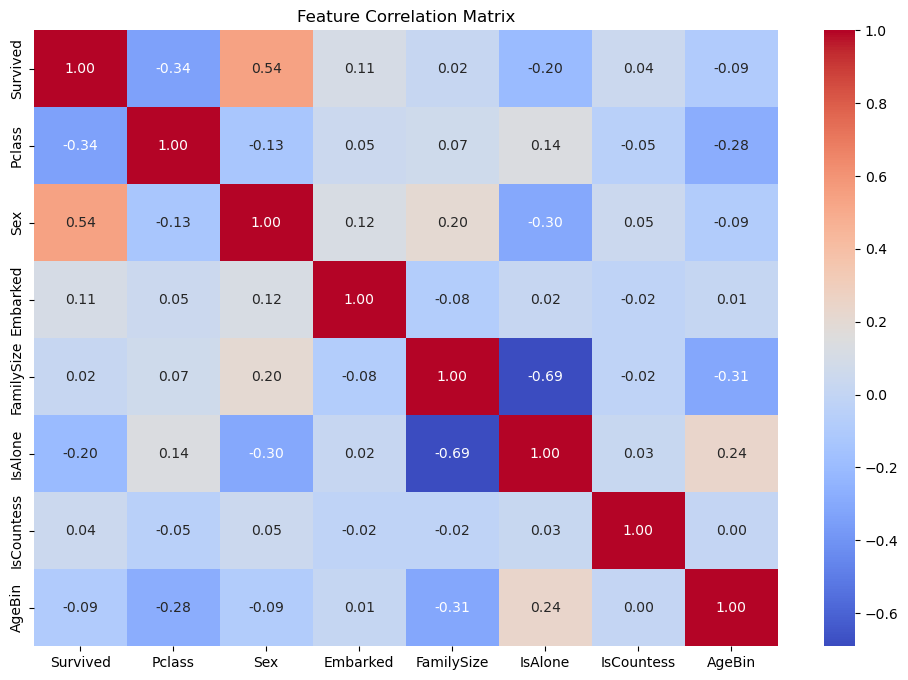

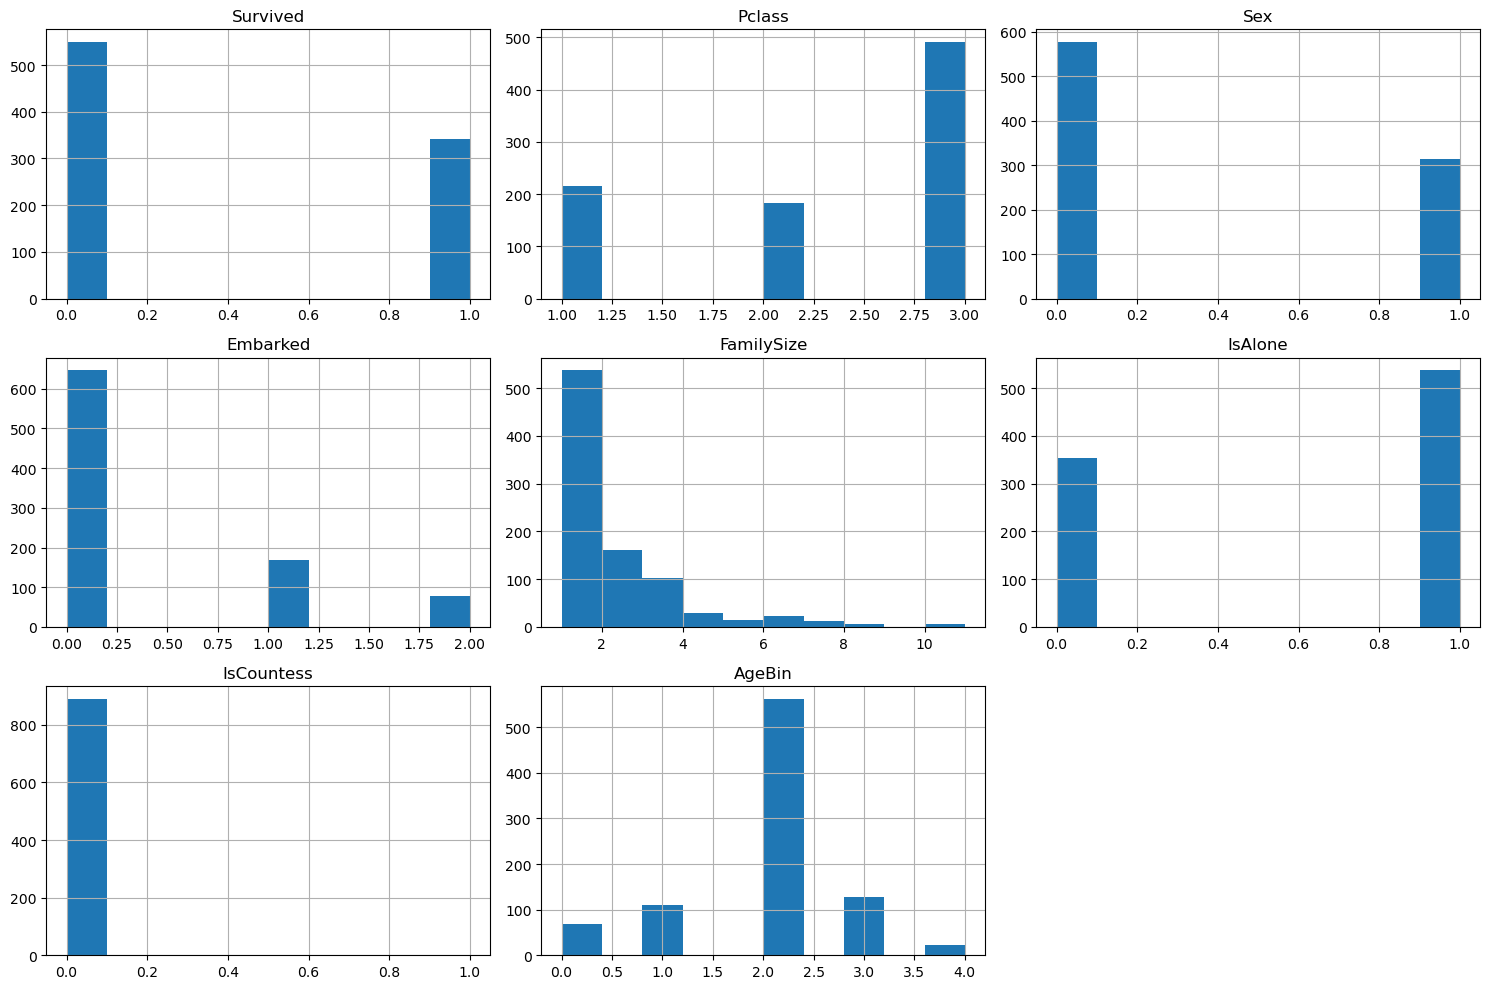

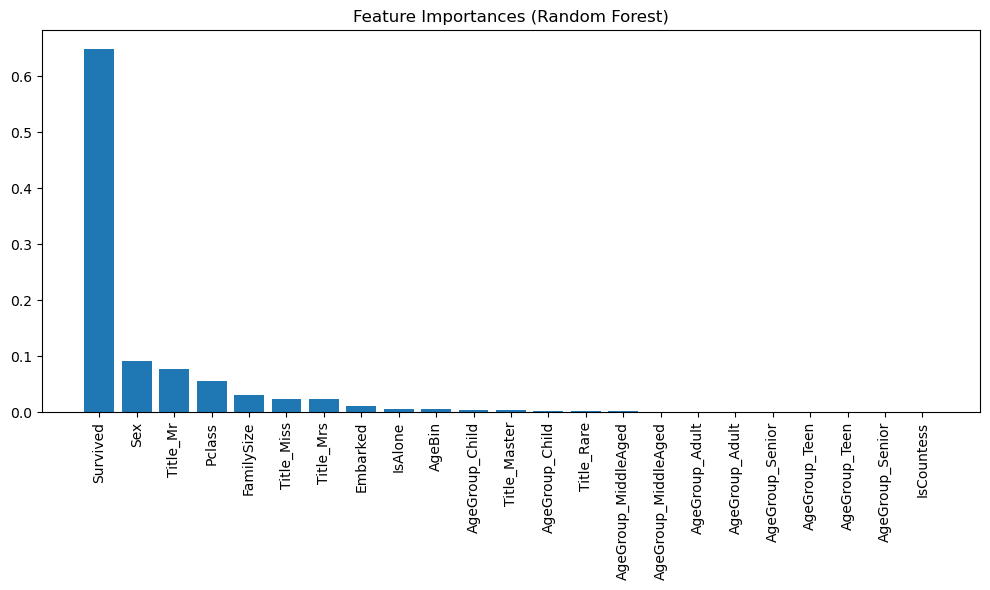

In [52]:
# EXPLORATORY DATA ANALYSIS
# ------ correlation matrix ------
plt.figure(figsize=(12,8))
# Only use numeric columns for correlation
numeric_cols = X_train_encoded.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

# ------ histograms of numeric features ------
# Only plot histograms for numeric columns
numeric_cols.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# ------ feature importances using Random Forest ------
# Convert boolean columns to int and category columns to codes
X_train_rf = X_train_encoded.copy()
for col in X_train_rf.select_dtypes(include=["bool"]).columns:
	X_train_rf[col] = X_train_rf[col].astype(int)
for col in X_train_rf.select_dtypes(include=["category"]).columns:
	X_train_rf[col] = X_train_rf[col].cat.codes
 
# Train a Random Forest model and plot feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names_plot = X_train_rf.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train_rf.shape[1]), importances[indices])
plt.xticks(range(X_train_rf.shape[1]), feature_names_plot[indices], rotation=90)
plt.tight_layout()
plt.show()

Logistic Regression CV score: 1.0000
Random Forest CV score: 1.0000
Decision Tree CV score: 1.0000
KNN CV score: 0.9405
SVM CV score: 0.9966


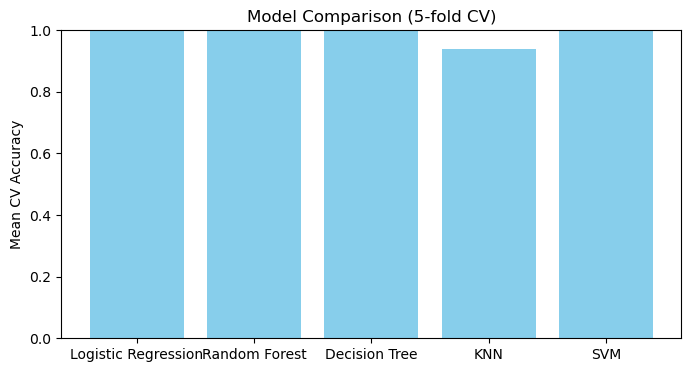

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best RF CV score: 1.0


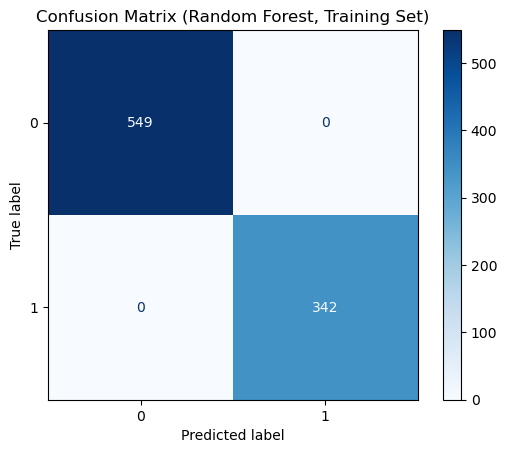

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       549
           1       1.00      1.00      1.00       342

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891



In [53]:
# MODEL TRAINING AND EVALUATION
# ------ CROSS-VALIDATION
# Model comparison using cross-validation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

cv_scores = {}
for name, model in models.items():
    score = cross_val_score(model, X_train_rf, y_train, cv=5).mean()
    cv_scores[name] = score
    print(f"{name} CV score: {score:.4f}")

plt.figure(figsize=(8,4))
plt.bar(cv_scores.keys(), cv_scores.values(), color='skyblue')
plt.ylabel("Mean CV Accuracy")
plt.title("Model Comparison (5-fold CV)")
plt.ylim(0, 1)
plt.show()

# ------ HYPERPARAMETER TUNING
# Using GridSearchCV for hyperparameter tuning
# Note: This is an example, you can adjust the parameters as needed

# Example: Random Forest hyperparameter tuning
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X_train_rf, y_train)
print("Best RF params:", rf_grid.best_params_)
print("Best RF CV score:", rf_grid.best_score_)

# Example: Logistic Regression hyperparameter tuning
# logreg_params = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'lbfgs']
# }
# logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, n_jobs=-1)
# logreg_grid.fit(X_train_rf, y_train)
# print("Best LogReg params:", logreg_grid.best_params_)
# print("Best LogReg CV score:", logreg_grid.best_score_)

# ------ FINAL MODEL TRAINING
# Predict on training set using encoded features
y_pred = rf.predict(X_train_rf)
cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Random Forest, Training Set)")
plt.show()

print(classification_report(y_train, y_pred))

In [54]:
# PREDICTION ON TEST SET
# ------ RANDOM FOREST PREDICTION
# Convert boolean and category columns in X_test to numeric types for prediction
X_test_rf = X_test_encoded.copy()
for col in X_test_rf.select_dtypes(include=["bool"]).columns:
    X_test_rf[col] = X_test_rf[col].astype(int)
for col in X_test_rf.select_dtypes(include=["category"]).columns:
    X_test_rf[col] = X_test_rf[col].cat.codes


# Train Random Forest on the encoded training set and create submission
# Convert boolean columns to int and category columns to codes
X_train_rf = X_train_encoded.copy()
for col in X_train_rf.select_dtypes(include=["bool"]).columns:
    X_train_rf[col] = X_train_rf[col].astype(int)
for col in X_train_rf.select_dtypes(include=["category"]).columns:
    X_train_rf[col] = X_train_rf[col].cat.codes
    
rf = RandomForestClassifier(n_estimators=100, max_depth= None, min_samples_split=2, random_state=42)
rf_score = cross_val_score(rf, X_train_rf, y_train, cv=5).mean()
print(f"Random Forest CV score: {rf_score:.4f}")
rf.fit(X_train_rf, y_train)
rf_predictions = rf.predict(X_train_rf)

# ------ LOGISTIC REGRESSION PREDICTION
# Train Logistic Regression on the encoded training set and create submission
# lr = LogisticRegression(max_iter=1000, C=0.1, solver='liblinear')
# lr_score = cross_val_score(lr, X_train_rf, y_train, cv=5).mean()
# print(f"Logistic Regression CV score: {lr_score:.4f}")
# lr.fit(X_train_encoded, y_train)
# lr_predictions = lr.predict(X_test_encoded)

Random Forest CV score: 1.0000


In [55]:
# EXPLORE A PATTERN
# Example: Explore a pattern in the data

# Make predictions on the test set
rf_test_predictions = rf.predict(X_test_rf)

# Compare your predictions with gender_submission
comparison = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "ModelPrediction": rf_test_predictions,
    "GenderSubmission": gender_submission["Survived"]
})

# Calculate accuracy
accuracy = (comparison["ModelPrediction"] == comparison["GenderSubmission"]).mean()
print(f"Agreement with gender_submission.csv: {accuracy:.4f}")

# Optionally, show mismatches
print(comparison[comparison["ModelPrediction"] != comparison["GenderSubmission"]])

# Percentage of women who survived in the training set
num_women = train[train["Sex"] == "female"].shape[0]
num_women_survived = train[(train["Sex"] == "female") & (train["Survived"] == 1)].shape[0]
percent_women_survived = num_women_survived / num_women * 100
print(f"Percentage of women who survived: {percent_women_survived:.2f}%")

# Percentage of men who survived in the training set
num_men = train[train["Sex"] == "male"].shape[0]
num_men_survived = train[(train["Sex"] == "male") & (train["Survived"] == 1)].shape[0]
percent_men_survived = num_men_survived / num_men * 100
print(f"Percentage of men who survived: {percent_men_survived:.2f}%")

# Percentage of people traveling alone who survived
num_alone = train[data[:len(train)]["IsAlone"] == 1].shape[0]
num_alone_survived = train[(data[:len(train)]["IsAlone"] == 1) & (train["Survived"] == 1)].shape[0]
percent_alone_survived = num_alone_survived / num_alone * 100
print(f"Percentage of people traveling alone who survived: {percent_alone_survived:.2f}%")

# Percentage of women traveling alone who survived in the training set
women_alone = train[(train["Sex"] == "female") & (data[:len(train)]["IsAlone"] == 1)]
num_women_alone = women_alone.shape[0]
num_women_alone_survived = women_alone[women_alone["Survived"] == 1].shape[0]
percent_women_alone_survived = num_women_alone_survived / num_women_alone * 100 if num_women_alone > 0 else 0
print(f"Percentage of women traveling alone who survived: {percent_women_alone_survived:.2f}%")

# Percentage of men traveling alone who survived in the training set
men_alone = train[(train["Sex"] == "male") & (data[:len(train)]["IsAlone"] == 1)]
num_men_alone = men_alone.shape[0]
num_men_alone_survived = men_alone[men_alone["Survived"] == 1].shape[0]
percent_men_alone_survived = num_men_alone_survived / num_men_alone * 100 if num_men_alone > 0 else 0
print(f"Percentage of men traveling alone who survived: {percent_men_alone_survived:.2f}%")

# Percentage of women aged 15 or below who survived in the training set
women_15_below = train[(train["Sex"] == "female") & (train["Age"] <= 15)]
num_women_15_below = women_15_below.shape[0]
num_women_15_below_survived = women_15_below[women_15_below["Survived"] == 1].shape[0]
percent_women_15_below_survived = num_women_15_below_survived / num_women_15_below * 100 if num_women_15_below > 0 else 0
print(f"Percentage of women aged 15 or below who survived: {percent_women_15_below_survived:.2f}%")

# Percentage of men aged 15 or below who survived in the training set
men_15_below = train[(train["Sex"] == "male") & (train["Age"] <= 15)]
num_men_15_below = men_15_below.shape[0]
num_men_15_below_survived = men_15_below[men_15_below["Survived"] == 1].shape[0]
percent_men_15_below_survived = num_men_15_below_survived / num_men_15_below * 100 if num_men_15_below > 0 else 0
print(f"Percentage of men aged 15 or below who survived: {percent_men_15_below_survived:.2f}%")

Agreement with gender_submission.csv: 0.6364
     PassengerId  ModelPrediction  GenderSubmission
1            893                0                 1
4            896                0                 1
6            898                0                 1
8            900                0                 1
12           904                0                 1
..           ...              ...               ...
409         1301                0                 1
410         1302                0                 1
411         1303                0                 1
412         1304                0                 1
414         1306                0                 1

[152 rows x 3 columns]
Percentage of women who survived: 74.20%
Percentage of men who survived: 18.89%
Percentage of people traveling alone who survived: 30.35%
Percentage of women traveling alone who survived: 78.57%
Percentage of men traveling alone who survived: 15.57%
Percentage of women aged 15 or below who survived: 65.12%

In [56]:
# SUBMISSION FILES
# ------ RANDOM FOREST SUBMISSION
submission_rf = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": rf.predict(X_test_rf)
})
submission_rf.to_csv("submission_rf.csv", index=False)
print("Submission file saved as 'submission_rf.csv'")

# --- LOGISTIC REGRESSION SUBMISSION
# submission_lr = pd.DataFrame({
#     "PassengerId": test_passenger_ids,
#     "Survived": lr_predictions
# })
# submission_lr.to_csv("submission_logreg.csv", index=False)
# print("Submission file saved as 'submission_logreg.csv'")

Submission file saved as 'submission_rf.csv'
